In [6]:
## Importing all the packages we need for the model!!
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from copy import deepcopy

In [7]:
df = pd.read_csv('MSFT.csv')

In [8]:
df


,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-21,53.500000,53.625000,51.625000,51.875000,32.294136,68416200
1,2000-01-24,51.898438,52.843750,50.406250,50.625000,31.515953,63597600
2,2000-01-25,50.500000,51.937500,49.781250,51.406250,32.002316,59823200
3,2000-01-26,51.218750,51.750000,49.562500,49.687500,30.932318,49365000
4,2000-01-27,49.945313,50.593750,48.625000,49.375000,30.737782,63654800
...,...,...,...,...,...,...,...
5905,2023-07-13,339.559998,343.739990,339.019989,342.660004,342.660004,20567200
5906,2023-07-14,347.589996,351.429993,344.309998,345.239990,345.239990,28302200
5907,2023-07-17,345.679993,346.989990,342.200012,345.730011,345.730011,20363900
5908,2023-07-18,345.829987,366.779999,342.170013,359.489990,359.489990,64872700


In [9]:
df = df[['Date', 'Close']]


In [10]:
df


,Date,Close
0,2000-01-21,51.875000
1,2000-01-24,50.625000
2,2000-01-25,51.406250
3,2000-01-26,49.687500
4,2000-01-27,49.375000
...,...,...
5905,2023-07-13,342.660004
5906,2023-07-14,345.239990
5907,2023-07-17,345.730011
5908,2023-07-18,359.489990


In [11]:
df['Date']

0       2000-01-21
1       2000-01-24
2       2000-01-25
3       2000-01-26
4       2000-01-27
           ...    
5905    2023-07-13
5906    2023-07-14
5907    2023-07-17
5908    2023-07-18
5909    2023-07-19
Name: Date, Length: 5910, dtype: object

In [12]:
def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('2000-01-21')

In [14]:
datetime.datetime(2000, 1, 21, 0, 0)

datetime.datetime(2000, 1, 21, 0, 0)

In [15]:
df

,Date,Close
0,2000-01-21,51.875000
1,2000-01-24,50.625000
2,2000-01-25,51.406250
3,2000-01-26,49.687500
4,2000-01-27,49.375000
...,...,...
5905,2023-07-13,342.660004
5906,2023-07-14,345.239990
5907,2023-07-17,345.730011
5908,2023-07-18,359.489990


In [16]:
df['Date'] = df['Date'].apply(str_to_datetime)


<ipython-input-16-82fc7f804c29>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].apply(str_to_datetime)


In [17]:
df['Date']

0      2000-01-21
1      2000-01-24
2      2000-01-25
3      2000-01-26
4      2000-01-27
          ...    
5905   2023-07-13
5906   2023-07-14
5907   2023-07-17
5908   2023-07-18
5909   2023-07-19
Name: Date, Length: 5910, dtype: datetime64[ns]

In [18]:
df.index = df.pop('Date')

In [19]:
df

,Close
Date,
2000-01-21,51.875000
2000-01-24,50.625000
2000-01-25,51.406250
2000-01-26,49.687500
2000-01-27,49.375000
...,...
2023-07-13,342.660004
2023-07-14,345.239990
2023-07-17,345.730011


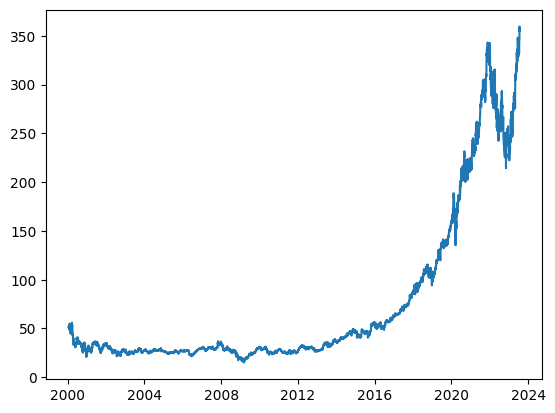

In [20]:
plt.plot(df.index, df['Close'])

In [21]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df,
                                '2021-03-25',
                                '2022-03-23',
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-03-25,235.990005,237.580002,235.460007,232.339996
1,2021-03-26,237.580002,235.460007,232.339996,236.479996
2,2021-03-29,235.460007,232.339996,236.479996,235.240005
3,2021-03-30,232.339996,236.479996,235.240005,231.850006
4,2021-03-31,236.479996,235.240005,231.850006,235.770004
...,...,...,...,...,...
247,2022-03-17,276.440002,287.149994,294.390015,295.220001
248,2022-03-18,287.149994,294.390015,295.220001,300.429993
249,2022-03-21,294.390015,295.220001,300.429993,299.160004
250,2022-03-22,295.220001,300.429993,299.160004,304.059998


In [22]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

In [23]:
dates.shape, X.shape, y.shape

((252,), (252, 3, 1), (252,))

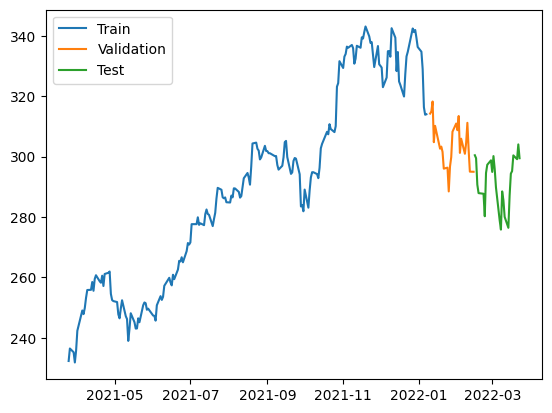

In [24]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=150)

Epoch 1/150
7/7 [==============================] - 4s 104ms/step - loss: 84770.2422 - mean_absolute_error: 289.4110 - val_loss: 92382.0000 - val_mean_absolute_error: 303.8569
Epoch 2/150
7/7 [==============================] - 0s 12ms/step - loss: 84449.9219 - mean_absolute_error: 288.8589 - val_loss: 92148.0234 - val_mean_absolute_error: 303.4717
Epoch 3/150
7/7 [==============================] - 0s 13ms/step - loss: 84236.3359 - mean_absolute_error: 288.4896 - val_loss: 91922.9375 - val_mean_absolute_error: 303.1006
Epoch 4/150
7/7 [==============================] - 0s 14ms/step - loss: 84001.0469 - mean_absolute_error: 288.0811 - val_loss: 91620.5469 - val_mean_absolute_error: 302.6013
Epoch 5/150
7/7 [==============================] - 0s 10ms/step - loss: 83691.7422 - mean_absolute_error: 287.5429 - val_loss: 91268.4375 - val_mean_absolute_error: 302.0190
Epoch 6/150
7/7 [==============================] - 0s 12ms/step - loss: 83325.1562 - mean_absolute_error: 286.9054 - val_loss: 90

7/7 [==============================] - 1s 5ms/step


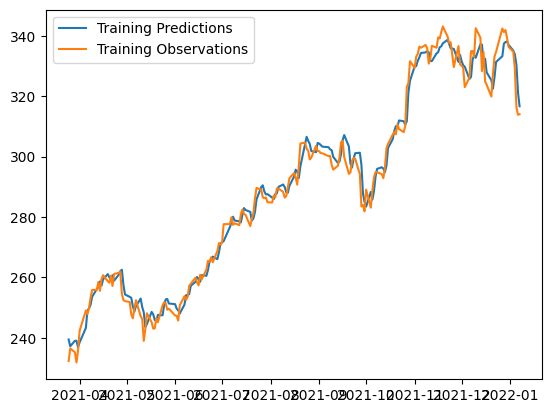

In [26]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

1/1 [==============================] - 0s 25ms/step


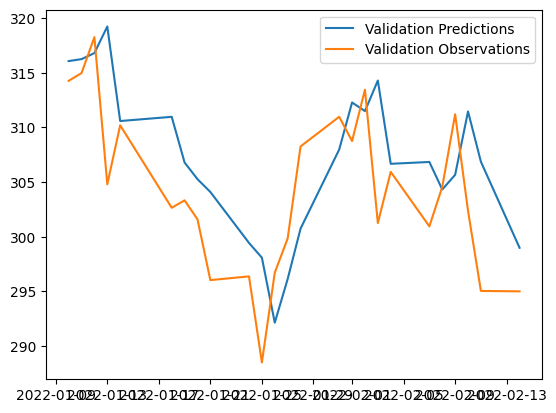

In [30]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

1/1 [==============================] - 0s 37ms/step


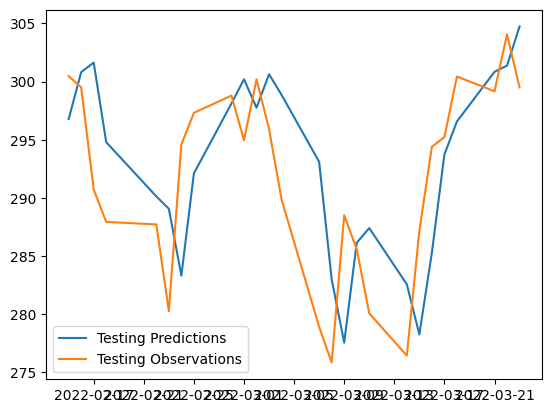

In [31]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

1/1 [==============================] - 0s 56ms/step


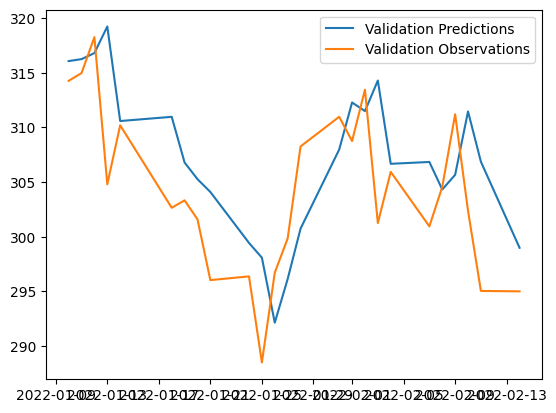

In [29]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

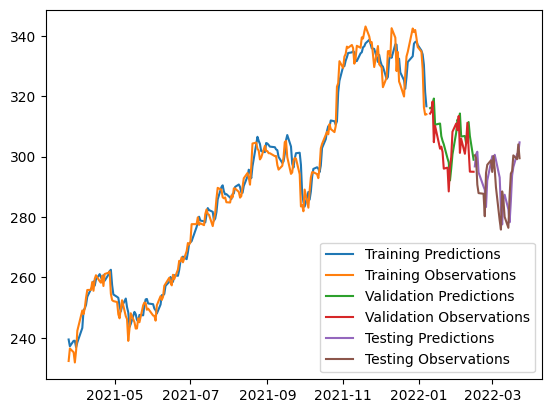

In [32]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

In [33]:
recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 [==============================] - 0s 23ms/step


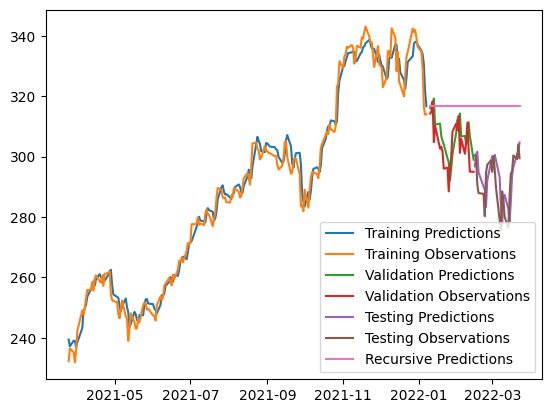

In [34]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations',
            'Recursive Predictions'])